In [4]:
# Python imports, put at the top for simplicity
from mdp_dp_rl.algorithms.dp.dp_analytic import DPAnalytic
from docs.notebooks.utils import render_service, render_target, render_composition_mdp, print_policy_data, print_value_function, print_q_value_function
from stochastic_service_composition.composition import composition_mdp
from stochastic_service_composition.services import build_service_from_transitions, Service
from stochastic_service_composition.target import build_target_from_transitions

## Use case for "Digital Twins Composition via Markov Decision Processes" - Ceramics Production.

In this notebook, we present the implementation of the use case for "Digital Twins Composition via Markov Decision Processes" about ceramics production.


# Available Services

In the following we provide definitions about available services:

In [5]:
DEFAULT_REWARD = -1.0
DEFAULT_BROKEN_REWARD = -10.0
DEFAULT_BROKEN_PROB = 0.05

#This is a preliminary function
def _build_device_service(action_name: str, broken_prob: float, broken_reward: float, action_reward: float):
    assert 0.0 <= broken_prob <= 1.0
    success_prob = 1.0 - broken_prob
    transitions = {
        "available": {
          action_name: ({"done": success_prob, "broken": broken_prob}, action_reward),
        },
        "broken": {
            f"check_{action_name}": ({"available": 1.0}, broken_reward),
        },
        "done": {
            f"check_{action_name}": ({"available": 1.0}, 0.0),
        }
    }
    final_states = {"available"}
    initial_state = "available"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore


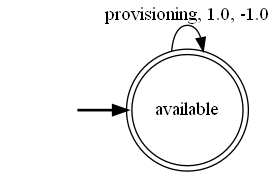

In [6]:
def provisioning_service(action_reward: float = DEFAULT_REWARD) -> Service:
    """Build the provisioning device."""
    transitions = {
        "available": {
            "provisioning": ({"available": 1.0}, action_reward),
        },
    }
    final_states = {"available"}
    initial_state = "available"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore
service_provisioning=provisioning_service()
render_service(service_provisioning)

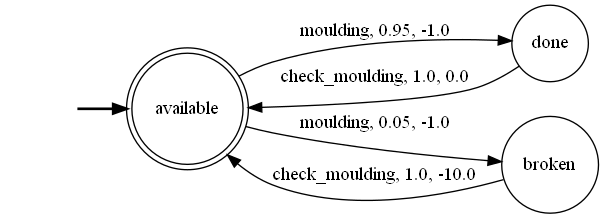

In [7]:
def moulding_service(broken_prob: float = DEFAULT_BROKEN_PROB, broken_reward: float = DEFAULT_BROKEN_REWARD, action_reward: float = DEFAULT_REWARD) -> Service:
    """Build the moulding device."""
    return _build_device_service("moulding", broken_prob=broken_prob, broken_reward=broken_reward, action_reward=action_reward)
service_moulding=moulding_service()
render_service(service_moulding)

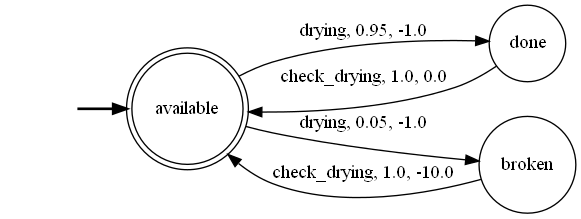

In [8]:
def drying_service(broken_prob: float = DEFAULT_BROKEN_PROB, broken_reward: float = DEFAULT_BROKEN_REWARD, action_reward: float = DEFAULT_REWARD) -> Service:
    """Build the drying device."""
    return _build_device_service("drying", broken_prob=broken_prob, broken_reward=broken_reward, action_reward=action_reward)
service_drying=drying_service()
render_service(service_drying)

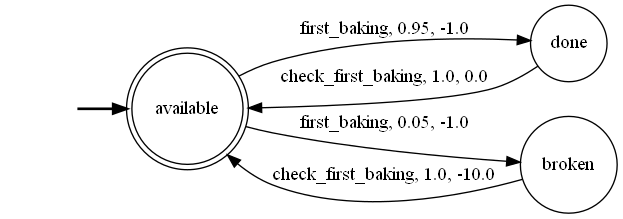

In [9]:
def first_baking_service(broken_prob: float = DEFAULT_BROKEN_PROB, broken_reward: float = DEFAULT_BROKEN_REWARD, action_reward: float = DEFAULT_REWARD) -> Service:
    """Build the first baking device."""
    return _build_device_service("first_baking", broken_prob=broken_prob, broken_reward=broken_reward, action_reward=action_reward)
service_first_baking=first_baking_service()
render_service(service_first_baking)

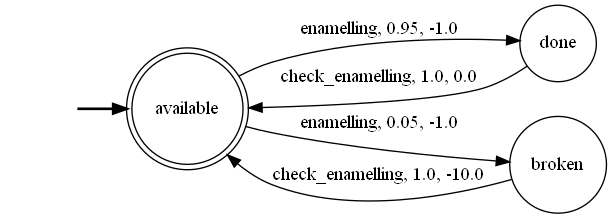

In [10]:
def enamelling(broken_prob: float = DEFAULT_BROKEN_PROB, broken_reward: float = DEFAULT_BROKEN_REWARD, action_reward: float = DEFAULT_REWARD) -> Service:
    """Build the enamelling device."""
    return _build_device_service("enamelling", broken_prob=broken_prob, broken_reward=broken_reward, action_reward=action_reward)
service_enamelling=enamelling()
render_service(service_enamelling)

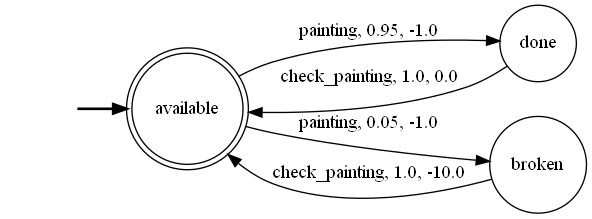

In [11]:
def painting_service(broken_prob: float = DEFAULT_BROKEN_PROB, broken_reward: float = DEFAULT_BROKEN_REWARD, action_reward: float = DEFAULT_REWARD) -> Service:
    """Build the painting device."""
    return _build_device_service("painting", broken_prob=broken_prob, broken_reward=broken_reward, action_reward=action_reward)
service_painting=painting_service()
render_service(service_painting)

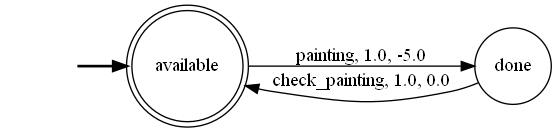

In [12]:
def painting_human_service(action_reward: float =-5.0) -> Service:
    """Build the painting device."""
    transitions = {
        "available": {
            "painting": ({"done": 1.0}, action_reward),
        },
        "done": {
            "check_painting": ({"available": 1.0}, 0.0),

        }
    }
    final_states = {"available"}
    initial_state = "available"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore
service_painting_human=painting_human_service()
render_service(service_painting_human)


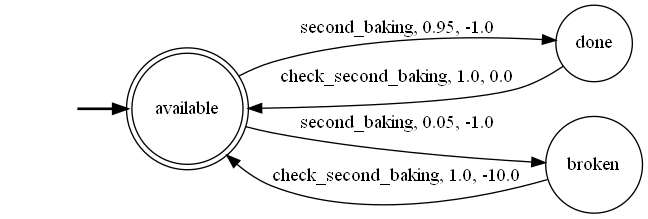

In [13]:
def second_baking_service(broken_prob: float = DEFAULT_BROKEN_PROB, broken_reward: float = DEFAULT_BROKEN_REWARD, action_reward: float = DEFAULT_REWARD) -> Service:
    """Build the second_baking device."""
    return _build_device_service("second_baking", broken_prob=broken_prob, broken_reward=broken_reward, action_reward=action_reward)
service_second_baking=second_baking_service()
render_service(service_second_baking)

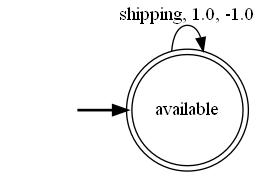

In [14]:
def shipping_service(action_reward: float = DEFAULT_REWARD) -> Service:
    """Build the shipping device."""
    transitions = {
        "available": {
            "shipping": ({"available": 1.0}, action_reward),
        },
    }
    final_states = {"available"}
    initial_state = "available"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore
service_shipping=shipping_service()
render_service(service_shipping)


# Target Specification
The target specification is defined as follows:

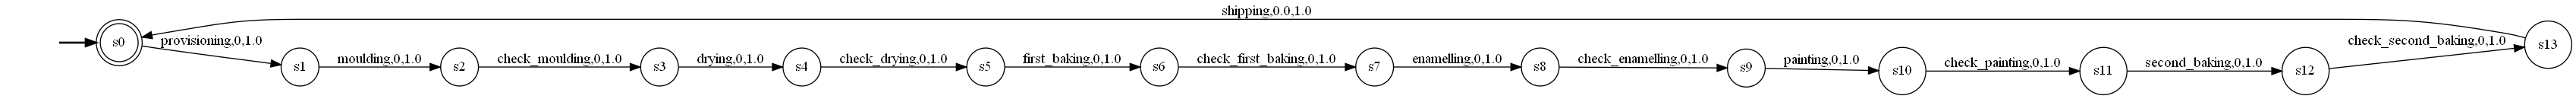

In [15]:
def target_service():
    """Build the target service."""
    transition_function = {
        "s0": {
            "provisioning": ("s1", 1.0, 0),
        },
        "s1": {"moulding": ("s2", 1.0, 0),
        },
        "s2": {"check_moulding": ("s3", 1.0, 0),},
        "s3": {"drying": ("s4", 1.0, 0), },
        "s4": {"check_drying": ("s5", 1.0, 0), },
        "s5": {"first_baking": ("s6", 1.0, 0), },
        "s6": {"check_first_baking": ("s7", 1.0, 0), },
        "s7": {"enamelling": ("s8", 1.0, 0), },
        "s8": {"check_enamelling": ("s9", 1.0, 0), },
        "s9": {"painting": ("s10", 1.0, 0), },
        "s10": {"check_painting": ("s11", 1.0, 0), },
        "s11": {"second_baking": ("s12", 1.0, 0), },
        "s12": {"check_second_baking": ("s13", 1.0, 0), },
        "s13": {"shipping": ("s0", 1.0, 0.0), },

    }

    initial_state = "s0"
    final_states = {"s0"}

    return build_target_from_transitions(
        transition_function, initial_state, final_states
    )

target = target_service()
render_target(target)

## Composition MDP
The Composition MDP is constructed in this way:

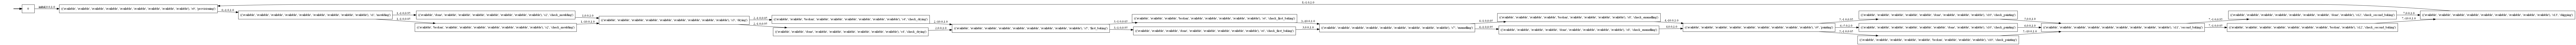

In [16]:
all_services = [
    service_provisioning,
    service_moulding,
    service_drying,
    service_first_baking,
    service_enamelling,
    service_painting,
    service_painting_human,
    service_second_baking,
    service_shipping,
]

mdp = composition_mdp(target, *all_services, gamma=0.9)
render_composition_mdp(mdp)

# Optimal policy
Calculation of optimal policy:

In [19]:
opn = DPAnalytic(mdp, 1e-4)
opt_policy = opn.get_optimal_policy_vi()
value_function = opn.get_value_func_dict(opt_policy)
q_value_function = opn.get_act_value_func_dict(opt_policy)

# remove '0' state to sort output
opt_policy.policy_data.pop(0, None)
value_function.pop(0, None)
_ = q_value_function.pop(0, None)


In [20]:
print_policy_data(opt_policy)


Policy:
State=(('available', 'available', 'available', 'available', 'available', 'available', 'available', 'available', 'available'), 's0', 'provisioning'),	Action=0
State=(('available', 'available', 'available', 'available', 'available', 'available', 'available', 'available', 'available'), 's1', 'moulding'),	Action=1
State=(('available', 'available', 'available', 'available', 'available', 'available', 'available', 'available', 'available'), 's11', 'second_baking'),	Action=7
State=(('available', 'available', 'available', 'available', 'available', 'available', 'available', 'available', 'available'), 's13', 'shipping'),	Action=8
State=(('available', 'available', 'available', 'available', 'available', 'available', 'available', 'available', 'available'), 's3', 'drying'),	Action=2
State=(('available', 'available', 'available', 'available', 'available', 'available', 'available', 'available', 'available'), 's5', 'first_baking'),	Action=3
State=(('available', 'available', 'available', 'availab

# Value Function
Calculation of Value Function:

In [21]:
print_value_function(value_function)


Value function:
State=(('available', 'available', 'available', 'available', 'available', 'available', 'available', 'available', 'available'), 's0', 'provisioning'),	value=-8.016734337200308
State=(('available', 'available', 'available', 'available', 'available', 'available', 'available', 'available', 'available'), 's1', 'moulding'),	value=-7.7963714857781214
State=(('available', 'available', 'available', 'available', 'available', 'available', 'available', 'available', 'available'), 's11', 'second_baking'),	value=-8.104199331819025
State=(('available', 'available', 'available', 'available', 'available', 'available', 'available', 'available', 'available'), 's13', 'shipping'),	value=-8.215060903480278
State=(('available', 'available', 'available', 'available', 'available', 'available', 'available', 'available', 'available'), 's3', 'drying'),	value=-7.835026525652001
State=(('available', 'available', 'available', 'available', 'available', 'available', 'available', 'available', 'available')

In [22]:
print_q_value_function(q_value_function)

Q-value function:
State=(('available', 'available', 'available', 'available', 'available', 'available', 'available', 'available', 'available'), 's0', 'provisioning'):
	Action=0,	Value=-8.016734337200308

State=(('available', 'available', 'available', 'available', 'available', 'available', 'available', 'available', 'available'), 's1', 'moulding'):
	Action=1,	Value=-7.796371485778121

State=(('available', 'available', 'available', 'available', 'available', 'available', 'available', 'available', 'available'), 's11', 'second_baking'):
	Action=7,	Value=-8.104199331819025

State=(('available', 'available', 'available', 'available', 'available', 'available', 'available', 'available', 'available'), 's13', 'shipping'):
	Action=8,	Value=-8.215060903480278

State=(('available', 'available', 'available', 'available', 'available', 'available', 'available', 'available', 'available'), 's3', 'drying'):
	Action=2,	Value=-7.835026525652

State=(('available', 'available', 'available', 'available', 'avail